In [269]:
import os

current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /Users/seongjinhyeon/Desktop/Project1/model/steel_model/1st


In [270]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# 업샘플링에 사용되는 라이브러리
from imblearn.over_sampling import ADASYN

In [271]:
# 모든 컬럼을 출력할 수 있도록 설정
pd.set_option('display.max_columns', None)

path = '../../../data/steel.csv'

df = pd.read_csv(path)
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


### 전처리 진행

In [272]:
# 일단 카피
df_clear = df.copy()
# 타겟특성 빼고 변수에 저장
df_clear = df_clear.drop(df_clear.iloc[:,-7:].columns, axis=1)
# Area라는 컬럼 생성
df_clear['Area'] = (df['X_Maximum'] - df['X_Minimum']) * (df['Y_Maximum'] - df['Y_Minimum'])
# Area컬럼을 생성하는데 사용된 피쳐 제거(X_Maximum, X_Minimum, Y_Maximum, Y_Minimum)
df_clear = df_clear.drop(df.iloc[:, :4].columns, axis=1)
# A300 제거(300 or 400이라 하나 제거 후 컬럼명 어떻게 할지 고민)
df_clear = df_clear.drop('TypeOfSteel_A300', axis=1)
# 일단 TypeOfSteel로만 변경해서 설명란에 0은 300 1은 400으로 해보기로
df_clear.rename(columns={'TypeOfSteel_A400':'TypeOfSteel'}, inplace=True)
# Log_X_index, Log_Y_index 제거 LogOFAreas가 합친결과값으로 판단되어 제거하기로 함
df_clear = df_clear.drop(['Log_X_Index', 'Log_Y_Index'], axis=1)
df_clear = df_clear.drop('Outside_Global_Index', axis=1)
df_clear.head()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Area
0,267,17,44,24220,76,108,1687,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,2.4265,0.8182,-0.2913,0.5822,352
1,108,10,30,11397,84,123,1687,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,2.0334,0.7931,-0.1756,0.2984,174
2,71,8,19,7972,99,125,1623,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.8513,0.6667,-0.1228,0.2150,108
3,176,13,45,18996,99,126,1353,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,2.2455,0.8444,-0.1568,0.5212,315
4,2409,60,260,246930,37,126,1353,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,3.3818,0.9338,-0.1992,1.0000,4369


In [273]:
df_clear.describe()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Area
count,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1.941000e+03
mean,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,1459.160227,0.599691,78.737764,0.331715,0.414203,0.570767,0.033361,0.610529,0.813472,2.492388,0.083288,-0.131305,0.585420,5.464301e+03
std,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,144.577823,0.490087,55.086032,0.299712,0.137261,0.271058,0.058961,0.243277,0.234274,0.788930,0.500868,0.148767,0.339452,6.271009e+04
min,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.048400,0.301000,-0.991000,-0.998900,0.119000,2.000000e+00
25%,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,1358.000000,0.000000,40.000000,0.060400,0.315800,0.361300,0.006600,0.411800,0.596800,1.924300,-0.333300,-0.195000,0.248200,1.360000e+02
50%,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,1364.000000,1.000000,70.000000,0.227300,0.412100,0.555600,0.010100,0.636400,0.947400,2.240600,0.095200,-0.133000,0.506300,3.060000e+02
75%,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,1650.000000,1.000000,80.000000,0.573800,0.501600,0.818200,0.023500,0.800000,1.000000,2.914900,0.511600,-0.066600,0.999800,1.610000e+03
max,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,300.000000,0.995200,0.943900,1.000000,0.875900,1.000000,1.000000,5.183700,0.991700,0.642100,1.000000,2.721150e+06


In [274]:
# 정규분포를 위한 log 변환

log_list = ['X_Perimeter',
'Y_Perimeter',
'Steel_Plate_Thickness',
# 'Edges_Index', # <- 0이 들어있어서 로그변환이 안됨 zerodivision_error
'Outside_X_Index',
'Area',
'Edges_Y_Index',
'Pixels_Areas',
'Sum_of_Luminosity']

for i in log_list:
    df_clear[i] = np.log(df_clear[i])

In [275]:
df_clear.head()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Area
0,5.587249,2.833213,3.784190,10.094934,76,108,1687,0,4.382027,0.0498,0.2415,0.1818,-5.360193,0.4706,0.000000,2.4265,0.8182,-0.2913,0.5822,5.863631
1,4.682131,2.302585,3.401197,9.341105,84,123,1687,0,4.382027,0.7647,0.3793,0.2069,-5.626821,0.6000,-0.033867,2.0334,0.7931,-0.1756,0.2984,5.159055
2,4.262680,2.079442,2.944439,8.983691,99,125,1623,0,4.605170,0.9710,0.3426,0.3333,-5.599422,0.7500,-0.054034,1.8513,0.6667,-0.1228,0.2150,4.682131
3,5.170484,2.564949,3.806662,9.851984,99,126,1353,1,5.669881,0.7287,0.4413,0.1556,-5.259097,0.5385,0.000000,2.2455,0.8444,-0.1568,0.5212,5.752573
4,7.786967,4.094345,5.560682,12.416860,37,126,1353,1,5.220356,0.0695,0.4486,0.0662,-4.374058,0.2833,-0.011567,3.3818,0.9338,-0.1992,1.0000,8.382289


In [276]:
y_list = list(df.iloc[:,-7:].columns)
df_target = df.copy()
df_target["Type"] = df_target.loc[:,y_list][y_list].idxmax(axis=1)
df_target = df_target.drop(columns=y_list)
display(df_target['Type'].value_counts())

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: Type, dtype: int64

In [277]:
# 이진분류를 위한 'Type' 컬럼 값 수정
df_target1 = df_target.copy()
df_target1['Type'] = df_target1['Type'].apply(lambda x: 1 if x != 'Other_Faults' else 0)
df_target1['Type'].value_counts(normalize=True)

1    0.653272
0    0.346728
Name: Type, dtype: float64

In [278]:
# 다중분류를 위한 'Type' 컬럼 값 수정
df_target2 = df_target.copy()
# 'Other_Faults'를 제외한 인덱스 가져오기
indices_to_remove = df_target2[df_target2['Type'] == 'Other_Faults'].index
# 해당 인덱스들을 제거하여 새로운 데이터프레임 생성
df_clear2 = df_clear.copy()
df_clear2 = df_clear.drop(indices_to_remove)
# 'Other_Faults' 행을 제외하고 결함이 있는 것만 남기기
df_target2 = df_target2[df_target2['Type'] != 'Other_Faults']
display(df_target2['Type'].value_counts(normalize=True))
encoder = LabelEncoder()
df_target2['Type'] = encoder.fit_transform(df_target2['Type'])
display(df_target2['Type'].value_counts(normalize=True))
# 라벨 인코딩된 값에 해당하는 원래 범주 확인
for encoded, original in enumerate(encoder.classes_):
    print(f"{encoded} -> {original}")

Bumps        0.317035
K_Scatch     0.308360
Z_Scratch    0.149842
Pastry       0.124606
Stains       0.056782
Dirtiness    0.043375
Name: Type, dtype: float64

0    0.317035
2    0.308360
5    0.149842
3    0.124606
4    0.056782
1    0.043375
Name: Type, dtype: float64

0 -> Bumps
1 -> Dirtiness
2 -> K_Scatch
3 -> Pastry
4 -> Stains
5 -> Z_Scratch


#### Base model 성능

[Epoch 10, lr 0.001]<br>

[Train Dataset] Loss = 16.039, Accuracy = 0.303<br>

[Test Dataset] Accuracy = 0.412<br>

#### 모델링 순서
- 크게 두가지 scaler 중 택 1(Standard, MinMax)
- 오버샘플링 할지 안할지 택 1
- 팀원분과 나누어서 분류모델로 RandomForest, Xgboost 모델 사용
- 별 모델 만들때 쓴 함수 가져와서 사용하기(ipynb파일이라 그냥 복사 붙여넣기로 가져옴...) -> 내용이 조금 달라서 수정
- 이진분류를 진행하고 다중분류를 진행하려 하기에 타겟값을 두종류로 나누어 모델 2개를 생성해야함

In [280]:
# 별 모델과 다르게 x_df, y_df를 매개변수로 적어두고 사용 -> x, y를 미리 나누어두고 진행해야해서..

def split_dataset(x_df, y_df, test_ratio = 0.2, select=1, upsampling=None):
    # 미리 전역변수로 설정해두기
    # global scaler -> 나중에 스케일링 저장하는데 문제가 생김
    
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=test_ratio, random_state=42, stratify=y_df)
    
    # 대표적인 표준화 두가지 중 택1
    if select == 1:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    # 타겟이 불균형하므로 오버샘플링을 해보기(매개변수를 지정안해주면 None이 실행되므로 if문에 안들어감 2가지 방법 실험용)
    # 스모트(SMOTE) 대신에 아다신(ADASYN) 사용된 이유는 좀 더 랜덤하게 업스케일링이 되게 하게 위해 사용
    if upsampling:
        adasyn = ADASYN(random_state=42)
        x_train, y_train = adasyn.fit_resample(x_train, y_train)
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_train = pd.DataFrame(x_train, columns=x_df.columns)
    x_test = pd.DataFrame(x_test, columns=x_df.columns)

    return x_train, x_test, y_train, y_test, scaler

In [59]:
def get_metrics(model, x_train, y_train):

    # 교차 검증 수행 및 평가 지표 계산
    scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
    }
    # 훈련 평가지표 출력
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print("훈련 정확도: ", model.score(x_train, y_train))
    print("훈련 recall: ", recall_score(y_train, y_pred))
    print("훈련 Precision: ", precision_score(y_train, y_pred))
    print("훈련 F1-score: ", f1_score(y_train, y_pred))

    # 교차검증 5개로 분할
    cv_results = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    
    # 교차 검증 결과를 데이터프레임으로 변환
    cv_results_df = pd.DataFrame(cv_results)
    
    # 평균값을 추가한 새로운 행을 생성하여 데이터프레임에 추가
    mean_scores = cv_results_df.mean().to_frame().T
    mean_scores.rename(index={0: 'mean'}, inplace=True)
    cv_results_df = pd.concat([cv_results_df, mean_scores], axis=0)

    return cv_results_df

### 이진분류 모델 start!!!
- df_clear, df_target1['Type'] 각 x, y로 사용
- 이진분류와 다중분류 모델을 각각 생성해야 함... 시간이 얼마나 걸릴지.. ㅎㅎ

In [85]:
df_clear.shape, df_target1['Type'].shape, df_clear2.shape, df_target2['Type'].shape

((1941, 20), (1941,), (1268, 20), (1268,))

- x_train1 생성하기
- select=1 로 설정하여 StandardScaler 사용 oversampling X
- 별모델과 똑같이 다양성을 위해 ADASYN 사용

In [86]:
x_train1, x_test1, y_train1, y_test1 = split_dataset(df_clear, df_target1['Type'], test_ratio = 0.2, select=1, upsampling=None)

In [87]:
print('훈련 데이터 shape:', x_train1.shape, y_train1.shape)
print('테스트 데이터 shape:', x_test1.shape, y_test1.shape)

훈련 데이터 shape: (1552, 20) (1552,)
테스트 데이터 shape: (389, 20) (389,)


In [88]:
print(y_train1.value_counts(normalize=True))
y_test1.value_counts(normalize=True)

1    0.653351
0    0.346649
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

- x_train2 생성
- select=1 로 설정하여 StandardScaler 사용 oversampling O

In [89]:
x_train2, x_test2, y_train2, y_test2 = split_dataset(df_clear, df_target1['Type'], test_ratio = 0.2, select=1, upsampling=1)

In [90]:
print('훈련 데이터 shape:', x_train2.shape, y_train2.shape)
print('테스트 데이터 shape:', x_test2.shape, y_test2.shape)

훈련 데이터 shape: (1989, 20) (1989,)
테스트 데이터 shape: (389, 20) (389,)


In [91]:
print(y_train2.value_counts(normalize=True))
y_test2.value_counts(normalize=True)

1    0.509804
0    0.490196
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

- x_train3 생성
- select=2 로 설정하여 MinMaxScaler 사용 oversampling X

In [92]:
x_train3, x_test3, y_train3, y_test3 = split_dataset(df_clear, df_target1['Type'], test_ratio=0.2, select=2)

In [93]:
print('훈련 데이터 shape:', x_train3.shape, y_train3.shape)
print('테스트 데이터 shape:', x_test3.shape, y_test3.shape)

훈련 데이터 shape: (1552, 20) (1552,)
테스트 데이터 shape: (389, 20) (389,)


In [94]:
print(y_train3.value_counts(normalize=True))
y_test3.value_counts(normalize=True)

1    0.653351
0    0.346649
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

- x_train4 생성
- select=2 로 설정하여 MinMaxScaler 사용 oversampling O

In [95]:
x_train4, x_test4, y_train4, y_test4 = split_dataset(df_clear, df_target1['Type'], test_ratio=0.2, select=2, upsampling=1)

In [96]:
print('훈련 데이터 shape:', x_train4.shape, y_train4.shape)
print('테스트 데이터 shape:', x_test4.shape, y_test4.shape)

훈련 데이터 shape: (1989, 20) (1989,)
테스트 데이터 shape: (389, 20) (389,)


In [97]:
print(y_train4.value_counts(normalize=True))
y_test4.value_counts(normalize=True)

1    0.509804
0    0.490196
Name: Type, dtype: float64


1    0.652956
0    0.347044
Name: Type, dtype: float64

## RandomForest random_state만 넣고 성능 확인 후 데이터 선정

In [98]:
# x_train1
rf_binary_model = RandomForestClassifier(random_state=42)
get_metrics(model=rf_binary_model, x_train=x_train1, y_train=y_train1)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.256522,0.010501,0.797428,0.891626,0.815315,0.851765
1,0.248364,0.010428,0.794212,0.911330,0.800866,0.852535
2,0.251556,0.010222,0.780645,0.896552,0.794760,0.842593
3,0.262013,0.010359,0.806452,0.886700,0.829493,0.857143
4,0.254986,0.010554,0.803226,0.881188,0.827907,0.853717
mean,0.254688,0.010413,0.796392,0.893479,0.813668,0.851550


In [99]:
# x_train2
get_metrics(model=rf_binary_model, x_train=x_train2, y_train=y_train2)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.334176,0.011326,0.783920,0.837438,0.762332,0.798122
1,0.330551,0.011319,0.804020,0.827586,0.796209,0.811594
2,0.327907,0.011496,0.821608,0.793103,0.847368,0.819338
3,0.327338,0.011368,0.854271,0.798030,0.905028,0.848168
4,0.323579,0.011401,0.848866,0.787129,0.903409,0.841270
mean,0.328710,0.011382,0.822537,0.808657,0.842869,0.823698


In [100]:
# x_train3
get_metrics(model=rf_binary_model, x_train=x_train3, y_train=y_train3)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.257211,0.010461,0.794212,0.886700,0.814480,0.849057
1,0.252253,0.010725,0.794212,0.911330,0.800866,0.852535
2,0.253868,0.010254,0.783871,0.896552,0.798246,0.844548
3,0.258603,0.010339,0.803226,0.886700,0.825688,0.855107
4,0.255339,0.010572,0.803226,0.881188,0.827907,0.853717
mean,0.255455,0.010470,0.795749,0.892494,0.813437,0.850993


In [102]:
# x_train4
get_metrics(model=rf_binary_model, x_train=x_train4, y_train=y_train4)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.324018,0.011217,0.783920,0.837438,0.762332,0.798122
1,0.326773,0.011401,0.804020,0.827586,0.796209,0.811594
2,0.322999,0.011046,0.821608,0.793103,0.847368,0.819338
3,0.326941,0.011270,0.854271,0.798030,0.905028,0.848168
4,0.320674,0.011184,0.848866,0.787129,0.903409,0.841270
mean,0.324281,0.011224,0.822537,0.808657,0.842869,0.823698


### x_train1이 가장 기본으로 돌릴때 성능이 좋음
### 07/25 오전 회의를 통해 정확도가 맞다고 판단되어 데이터를 바꾸기로 결정
- accuracy	recall	    precision	    f1_score
- 0.796392	0.893479	0.813668	    0.851550
- 훈련데이터에 과적합이 심하다고 생각함
### x_train4로 변경
- accuracy	recall	    precision	    f1_score
- 0.822537	0.808657	0.842869	    0.823698

In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

- 07/24 23:20분 돌려놓고 잘 준비.. 랜덤서치로 최대한 조합수 많이 넣어놓자..
- 이진분류는 accuracy 기준으로 돌려봄
- 확실한게 좋다고 생각해서

In [114]:
rf_binary_model = RandomForestClassifier(random_state=42,
                                         class_weight='balanced',
                                         bootstrap=False)

param_dist = {
    'n_estimators': randint(300, 500), # 이 값을 늘리면 더 많은 트리를 사용하여 예측을 평균화하므로 일반화 성능을 향상시킬 수 있다.
    'max_depth': randint(15, 30), # 작은 값으로 설정하면 트리의 복잡성이 줄어들어 과적합을 방지
    'min_samples_split': randint(2, 10), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'min_samples_leaf': randint(2, 5), # 큰 값으로 설정하면 과적합을 방지하는 데 도움
    'max_features' : randint(2, 10), # 특성 수를 제한하여 과적합을 줄일 수 있다.
}

# 랜덤 서치 수행
random_search = RandomizedSearchCV(
    rf_binary_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy')

# 학습 데이터에 랜덤 서치 수행
random_search.fit(x_train4, y_train4)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", random_search.best_params_)
print("최고 accuracy_score: ", random_search.best_score_)

최적의 하이퍼파라미터:  {'max_depth': 18, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 308}
최고 accuracy_score:  0.84013518473982


- 1번째 랜덤서치
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 17, 'max_features': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 304}
최고 f1_score:  0.8460733433296797

- 2번째 랜덤서치
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 21, 'max_features': 15, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 441}
최고 f1_score:  0.8453989559577655

- 3번째 랜덤서치
최적의 하이퍼파라미터:  {'bootstrap': True, 'max_depth': 25, 'max_features': 17,'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 373}
최고 f1_score:  0.8513466975273782

- 4번째 랜덤서치(accuracy기준으로 하기로 결정해서 다시) x_train4
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 16, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 320}
최고 accuracy_score:  0.835108793336962

- 5번째 랜덤서치
최적의 하이퍼파라미터:  {'bootstrap': False, 'max_depth': 24, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 350}
최고 accuracy_score:  0.8411427414148831

- 6번째 랜덤서치
최적의 하이퍼파라미터:  {'max_depth': 18, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 308}
최고 accuracy_score:  0.84013518473982

### GridSearch

In [117]:
# 모델 생성
rf_grid_model = RandomForestClassifier(random_state=42,
                               class_weight='balanced',
                               bootstrap=False,
                               min_samples_leaf=2)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'n_estimators': [330, 340, 350, 360],  # 결정 트리 개수 후보
    'max_depth': [16, 17, 18],  # 최대 깊이 후보
    'min_samples_split': [2, 3, 4],  # 노드를 분할하기 위한 최소 샘플 수 후보
    'max_features': [7, 8, 9, 10]
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(rf_grid_model, param_grid, cv=5, scoring='accuracy')

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train4, y_train4)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 accuracy:", grid_search.best_score_)

최적의 하이퍼파라미터: {'max_depth': 17, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 340}
최고 accuracy: 0.8411427414148829


- 그리드서치 1번째
최적의 하이퍼파라미터: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
최고 Recall: 0.848582527287854 -> max_features 빼먹음.. ㅜㅜ

- 그리드서치 2번째 x_train4로 바꿈 accuracy 기준!
최적의 하이퍼파라미터: {'max_depth': 18, 'max_features': 6, 'min_samples_split': 3, 'n_estimators': 323}
최고 accuracy: 0.8406402288520688

- 그리드서치 3번째
최적의 하이퍼파라미터: {'max_depth': 17, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 340}
최고 accuracy: 0.8411427414148829

- 그리드서치 4번째
최적의 하이퍼파라미터: {'max_depth': 17, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 340}
최고 accuracy: 0.8411427414148829

In [120]:
rf_final_model = RandomForestClassifier(random_state=42,
                               class_weight='balanced',
                               bootstrap=False,
                               min_samples_leaf=2,
                               max_depth=17,
                               max_features=8,
                               min_samples_split=2,
                               n_estimators=340)

rf_final_model.fit(x_train4, y_train4)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=17,
                       max_features=8, min_samples_leaf=2, n_estimators=340,
                       random_state=42)

In [121]:
y_test_pred = rf_final_model.predict(x_test4)
print("테스트 정확도: ", accuracy_score(y_test4, y_test_pred))
print("테스트 recall: ", recall_score(y_test4, y_test_pred))
print("테스트 Precision: ", precision_score(y_test4, y_test_pred))
print("테스트 F1-score: ", f1_score(y_test4, y_test_pred))

테스트 정확도:  0.7866323907455013
테스트 recall:  0.8188976377952756
테스트 Precision:  0.8489795918367347
테스트 F1-score:  0.8336673346693387


#### 성능이 별로 좋지 못했다..
- 같이 머신러닝 돌리는 팀원분이 cpu성능이 좋으셔서 다른 여러모델을 많이 확인해주셨다.. 맥북 어째서.. ㅜㅜ

### 다중분류 start!!

In [281]:
df_clear2.shape, df_target2['Type'].shape

((1268, 20), (1268,))

In [282]:
x_train5, x_test5, y_train5, y_test5, scaler5 = split_dataset(df_clear2, df_target2['Type'], test_ratio = 0.2, select=1, upsampling=None)

In [283]:
print('훈련 데이터 shape:', x_train5.shape, y_train5.shape)
print('테스트 데이터 shape:', x_test5.shape, y_test5.shape)

print(y_train5.value_counts(normalize=True))
y_test5.value_counts(normalize=True)

훈련 데이터 shape: (1014, 20) (1014,)
테스트 데이터 shape: (254, 20) (254,)
0    0.316568
2    0.308679
5    0.149901
3    0.124260
4    0.057199
1    0.043393
Name: Type, dtype: float64


0    0.318898
2    0.307087
5    0.149606
3    0.125984
4    0.055118
1    0.043307
Name: Type, dtype: float64

In [284]:
x_train6, x_test6, y_train6, y_test6, scaler6 = split_dataset(df_clear2, df_target2['Type'], test_ratio = 0.2, select=1, upsampling=1)

In [285]:
print('훈련 데이터 shape:', x_train6.shape, y_train6.shape)
print('테스트 데이터 shape:', x_test6.shape, y_test6.shape)

print(y_train6.value_counts(normalize=True))
y_test6.value_counts(normalize=True)

훈련 데이터 shape: (1940, 20) (1940,)
테스트 데이터 shape: (254, 20) (254,)
5    0.173711
1    0.172165
4    0.166495
0    0.165464
2    0.163918
3    0.158247
Name: Type, dtype: float64


0    0.318898
2    0.307087
5    0.149606
3    0.125984
4    0.055118
1    0.043307
Name: Type, dtype: float64

In [286]:
x_train7, x_test7, y_train7, y_test7, scaler7 = split_dataset(df_clear2, df_target2['Type'], test_ratio = 0.2, select=2, upsampling=None)

In [287]:
print('훈련 데이터 shape:', x_train7.shape, y_train7.shape)
print('테스트 데이터 shape:', x_test7.shape, y_test7.shape)

print(y_train7.value_counts(normalize=True))
y_test7.value_counts(normalize=True)

훈련 데이터 shape: (1014, 20) (1014,)
테스트 데이터 shape: (254, 20) (254,)
0    0.316568
2    0.308679
5    0.149901
3    0.124260
4    0.057199
1    0.043393
Name: Type, dtype: float64


0    0.318898
2    0.307087
5    0.149606
3    0.125984
4    0.055118
1    0.043307
Name: Type, dtype: float64

In [288]:
x_train8, x_test8, y_train8, y_test8, scaler8 = split_dataset(df_clear2, df_target2['Type'], test_ratio = 0.2, select=2, upsampling=1)

In [289]:
print('훈련 데이터 shape:', x_train8.shape, y_train8.shape)
print('테스트 데이터 shape:', x_test8.shape, y_test8.shape)

print(y_train8.value_counts(normalize=True))
y_test8.value_counts(normalize=True)

훈련 데이터 shape: (1940, 20) (1940,)
테스트 데이터 shape: (254, 20) (254,)
5    0.173711
1    0.172165
4    0.166495
0    0.165464
2    0.163918
3    0.158247
Name: Type, dtype: float64


0    0.318898
2    0.307087
5    0.149606
3    0.125984
4    0.055118
1    0.043307
Name: Type, dtype: float64

### 동료분의 cpu를 활용해 일단 xgboost를 맡아서 하기로 -> 랜덤포레스트모델이 조금 느린편

In [290]:
### get_metrix 함수 다중분류를 위해 조금 수정

def get_metrics_multiple(model, x_train, y_train, average='micro'):
    # 교차 검증 수행 및 평가 지표 계산
    scoring = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}

    # 훈련 평가지표 출력
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    print("훈련 정확도: ", model.score(x_train, y_train))
    print("훈련 recall: ", recall_score(y_train, y_pred, average=average))
    print("훈련 Precision: ", precision_score(y_train, y_pred, average=average))
    print("훈련 F1-score: ", f1_score(y_train, y_pred, average=average))

    # 교차검증 5개로 분할
    cv_results = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)

    # 교차 검증 결과를 데이터프레임으로 변환
    cv_results_df = pd.DataFrame(cv_results)

    # 평균값을 추가한 새로운 행을 생성하여 데이터프레임에 추가
    mean_scores = cv_results_df.mean().to_frame().T
    mean_scores.rename(index={0: 'mean'}, inplace=True)
    cv_results_df = pd.concat([cv_results_df, mean_scores], axis=0)

    return cv_results_df

In [291]:
# x_train5
xgb_model = XGBClassifier(random_state=42)
get_metrics_multiple(model=xgb_model, x_train=x_train5, y_train=y_train5)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.409573,0.004864,0.862069,0.817530,0.847281,0.830930
1,0.398011,0.005043,0.901478,0.857841,0.919234,0.881438
2,0.422274,0.004723,0.916256,0.885856,0.937289,0.907328
3,0.422750,0.005988,0.906404,0.854172,0.877200,0.863061
4,0.413903,0.006211,0.925743,0.909358,0.924225,0.916407
mean,0.413302,0.005366,0.902390,0.864951,0.901046,0.879833


In [292]:
# x_train6
get_metrics_multiple(model=xgb_model, x_train=x_train6, y_train=y_train6)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.905001,0.005333,0.907216,0.906924,0.908380,0.907069
1,0.676281,0.010463,0.951031,0.949770,0.950409,0.949791
2,0.780561,0.005355,0.963918,0.964026,0.964136,0.963495
3,0.580388,0.005037,0.953608,0.953580,0.954472,0.952585
4,0.647001,0.005172,0.966495,0.966012,0.966356,0.965858
mean,0.717846,0.006272,0.948454,0.948062,0.948751,0.947759


In [293]:
# x_train7
get_metrics_multiple(model=xgb_model, x_train=x_train7, y_train=y_train7)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.298364,0.004580,0.862069,0.817530,0.847281,0.830930
1,0.485526,0.005989,0.901478,0.857841,0.919234,0.881438
2,0.541538,0.004909,0.916256,0.885856,0.937289,0.907328
3,0.419679,0.004715,0.906404,0.854172,0.877200,0.863061
4,0.449528,0.010325,0.925743,0.909358,0.924225,0.916407
mean,0.438927,0.006104,0.902390,0.864951,0.901046,0.879833


In [294]:
# x_train8
get_metrics_multiple(model=xgb_model, x_train=x_train8, y_train=y_train8)

훈련 정확도:  1.0
훈련 recall:  1.0
훈련 Precision:  1.0
훈련 F1-score:  1.0


,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1_score
0,0.616775,0.005427,0.907216,0.906924,0.908380,0.907069
1,0.783163,0.005736,0.951031,0.949770,0.950409,0.949791
2,0.691963,0.005043,0.963918,0.964026,0.964136,0.963495
3,0.605517,0.005196,0.953608,0.953580,0.954472,0.952585
4,0.617660,0.005190,0.966495,0.966012,0.966356,0.965858
mean,0.663016,0.005318,0.948454,0.948062,0.948751,0.947759


### xgboost 다중분류 x_train6, 8이 좋음 fit_time, score_time만 조금 다름
- 오버샘플링 한 데이터들
- 조금이라도 fit_time이 빠른 6번으로 일단 진행!!!

In [176]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb_model = XGBClassifier(random_state=42)

param_dist = {
    'eta': uniform(0.1, 0.6),
    'max_depth': randint(10, 20),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0, 1)
}

# 랜덤 서치 수행
xgb_random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=200, cv=5, scoring='f1_weighted')

# 학습 데이터에 랜덤 서치 수행
xgb_random_search.fit(x_train6, y_train6)

# 최적의 하이퍼파라미터와 평가 지표 출력
print("최적의 하이퍼파라미터: ", xgb_random_search.best_params_)
print("최고 f1_score: ", xgb_random_search.best_score_)

최적의 하이퍼파라미터:  {'eta': 0.2449233044643096, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6155850256247313}
최고 f1_score:  0.9534034521005614


- 1번째 랜덤서치 -> 20가지 방법으로 돌림 다음부터 100가지 방법정도
최적의 하이퍼파라미터:  {'eta': 0.5136114215641763, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.6480291768734825}
최고 f1_score:  0.9497623460164458

- 2번째 랜덤서치
최적의 하이퍼파라미터:  {'eta': 0.3715863440725103, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.7684493551941742}
최고 f1_score:  0.9539657460998854

- 3번째 랜덤서치
최적의 하이퍼파라미터:  {'eta': 0.5210914882011322, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9346332957610737}
최고 f1_score:  0.9513202848127182

- 4번째 랜덤서치
최적의 하이퍼파라미터:  {'eta': 0.3562024457441226, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.7607811576838809}
최고 f1_score:  0.9536565449751494

- 5번째 랜덤서치
최적의 하이퍼파라미터:  {'eta': 0.3094142536522143, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.8586832681130361}
최고 f1_score:  0.9535738665727619

- 6번째 랜덤서치 -> f1_macro에서 f1_weighted 로 변경(테스트데이터가 불균형하기에 학습데이터부터 통일하기로)
최적의 하이퍼파라미터:  {'eta': 0.22279437833002427, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.4525036375409023}
최고 f1_score:  0.9539303174441611

- 7번째 랜덤서치
최적의 하이퍼파라미터:  {'eta': 0.2449233044643096, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6155850256247313}
최고 f1_score:  0.9534034521005614

### xgb gridsearch start!!
- 소수점으로 들어가는 데이터들이 많아서 그리드보다 랜덤이 더 괜찮아 보이기도 함...

In [164]:
# 모델 생성
xgb_model = XGBClassifier(random_state=42,
                          eta=0.3715863440725103)

# 하이퍼파라미터 후보들을 딕셔너리 형태로 정의
param_grid = {
    'max_depth': [13, 14, 15, 16, 17],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.75, 0.8, 0.85]
}

# Recall을 사용하여 그리드 서치 수행
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_weighted')

# 학습 데이터에 그리드 서치 수행
grid_search.fit(x_train6, y_train6)

# 최적의 파라미터와 성능 확인
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 f1_score:", grid_search.best_score_)

최적의 하이퍼파라미터: {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8}
최고 f1_score: 0.9555528309977743


- 그리드 1번째
최적의 하이퍼파라미터: {'eta': 0.3715863440725103, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.9}
최고 f1_score: 0.9519846420741394

- 그리드 2번째
최적의 하이퍼파라미터: {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8}
최고 f1_score: 0.9555528309977743

- 그리드 3번째
최적의 하이퍼파라미터: {'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.85}
최고 f1_score: 0.9540633169862316

- 그리드 4번째
최적의 하이퍼파라미터: {'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8}
최고 f1_score: 0.9555528309977743

- 7번째 랜덤서치
최적의 하이퍼파라미터:  {'eta': 0.2449233044643096, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6155850256247313}
최고 f1_score:  0.9534034521005614

In [295]:
xgb_final_model = XGBClassifier(random_state=42,
                          eta=0.2449233044643096,
                          max_depth=13,
                          min_child_weight=1,
                          subsample=0.6155850256247313)

xgb_final_model.fit(x_train6, y_train6)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.2449233044643096, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.244923308,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob', ...)

In [296]:
y_test_pred = xgb_final_model.predict(x_test6)
print("테스트 정확도: ", accuracy_score(y_test6, y_test_pred))
print("테스트 recall: ", recall_score(y_test6, y_test_pred, average='weighted'))
print("테스트 Precision: ", precision_score(y_test6, y_test_pred, average='weighted'))
print("테스트 F1-score: ", f1_score(y_test6, y_test_pred, average='weighted'))

테스트 정확도:  0.9212598425196851
테스트 recall:  0.9212598425196851
테스트 Precision:  0.9252445717012646
테스트 F1-score:  0.9220573926299338


0 -> Bumps
1 -> Dirtiness
2 -> K_Scatch
3 -> Pastry
4 -> Stains
5 -> Z_Scratch

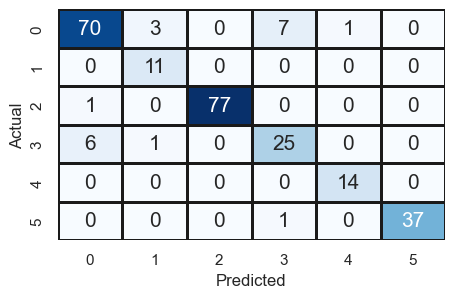

In [297]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (5, 3))
sns.heatmap(confusion_matrix(y_test6, y_test_pred), cmap = 'Blues',
            cbar = False, annot = True, annot_kws = {'size' : 15},
            fmt = '.0f',
            linecolor = 'k', linewidths = 0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [298]:
from sklearn.metrics import classification_report

print(classification_report(y_test6, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89        81
           1       0.73      1.00      0.85        11
           2       1.00      0.99      0.99        78
           3       0.76      0.78      0.77        32
           4       0.93      1.00      0.97        14
           5       1.00      0.97      0.99        38

    accuracy                           0.92       254
   macro avg       0.89      0.93      0.91       254
weighted avg       0.93      0.92      0.92       254



In [299]:
import pickle

# 모델 피클링 (저장)
with open('xgb_model_multy.pkl', 'wb') as file:
    pickle.dump(xgb_final_model, file)

In [300]:
with open('xgb_scaler_multy.pkl', 'wb') as file:
    pickle.dump(scaler6, file)